# Plot patient features

## Load ICU sepsis data log

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as m
%matplotlib inline
path = '../training/'

In [2]:
# Choose patient sample (example)
sample_num = 785

In [3]:
# Import and print dataframe layout
def loadICUdata(sample_num, path = './', printdf = False):
    samplestr = 'p' + (str(sample_num) + '.psv').rjust(9, '0')
    fname = path + samplestr
    df = pd.read_csv(fname, sep = '|')
    #print(fname, ' file:')
    if printdf:
        print(df)
    return df

df = loadICUdata(sample_num, path, False)
#df

## Check sepsis labels for ALL patients

In [4]:
# get the sepsis label value
def get_sepsislabel(df):
    sl = df[["SepsisLabel"]]
    count = df['SepsisLabel'].value_counts()
    count_healthy = -1
    count_sep = -1
    
    if len(count) == 2:
        count_sep = count[1]
        count_healthy = count[0]
        
    elif len(count) == 1:
        if sl.values[0] == 0:
            count_healthy = count.values[0]
        elif sl.values[0] == 1:
            count_sep = count.values[0]
    return sl, count_healthy, count_sep


In [5]:
count = df['SepsisLabel'].value_counts()
count.values
len(count)
sl, ch, cs = get_sepsislabel(df)
len(sl)

260

In [6]:
# Print result
sl, ch, cs = get_sepsislabel(df) 
print('patient {:d}, {:d} {:d} {:2.2f}%'.format(sample_num, ch, cs, 100*cs/len(sl)))

patient 785, 260 -1 -0.38%


## Loop study, sepsis presence

In [7]:
# Run in a loop and get a sepsis presence report
SL = []    #Sepsis labels
CH = []    #Healthy hours count
CS = []    #Sepsis hours count
CSCH = []  #Percentage cs/(cs+ch)
DATA = []  #DATA structure
for i in range(1,5001):
    df = loadICUdata(i, path, False)
    DATA.append(df) 
    sl, ch, cs = get_sepsislabel(df) 
    SL.append(sl)
    CH.append(ch)
    CS.append(cs)
    if cs != -1 and ch != -1:
        csch = 1.0*cs/(cs + ch)
    elif cs == -1:
        csch = 0
    elif ch == -1:
        csch = 1
    CSCH.append(csch)
    
CSCH = np.array(CSCH)

In [8]:
# Count sepsis patients
print(CSCH, np.count_nonzero(CSCH))

[0. 0. 0. ... 0. 0. 0.] 279


In [9]:
sepsis_idx = np.where(CSCH!=0)

In [10]:
# Check percentage of sepsis hours for sepsis patients
CSCH[sepsis_idx]

array([0.11111111, 0.02214022, 0.27777778, 0.11363636, 1.        ,
       0.09615385, 0.28571429, 0.33333333, 0.25641026, 0.14754098,
       1.        , 0.2195122 , 1.        , 0.07627119, 0.04975124,
       0.15151515, 0.09183673, 0.37037037, 0.20408163, 0.06944444,
       0.04587156, 0.625     , 0.07894737, 0.09183673, 0.24390244,
       1.        , 0.03846154, 0.2       , 0.10465116, 0.76923077,
       0.76923077, 0.27777778, 0.225     , 0.17857143, 1.        ,
       0.08256881, 0.20408163, 0.16981132, 0.14084507, 0.81818182,
       0.0990099 , 0.43478261, 0.12820513, 0.09803922, 0.33333333,
       0.13461538, 0.41666667, 1.        , 0.11627907, 0.08333333,
       0.23255814, 0.66666667, 0.29411765, 1.        , 0.90909091,
       0.38461538, 0.03125   , 0.07246377, 0.04291845, 0.20833333,
       1.        , 0.16393443, 0.90909091, 0.22727273, 1.        ,
       0.33333333, 0.13888889, 0.4       , 0.35714286, 0.25641026,
       0.17307692, 0.15384615, 0.4       , 0.625     , 1.     

## Matrix Sepsis

In [11]:
def get_dfmaxcount(list_of_lists):
    maxval = -1
    maxval_i = -1
    for i in range(len(list_of_lists)):
        val = list_of_lists[i].count(axis = 0)[0]
        if val > maxval:
            maxval = val
            maxval_i = i
    return maxval, maxval_i

In [12]:
# get max val in SepsisLabel count and idx position
mv, mvi = get_dfmaxcount(SL)

In [13]:
mv, mvi

(336, 1921)

In [14]:
# Initialize sepsis matrix
sepsis_matrix = -1 * np.ones((len(SL),mv), dtype=int)
for i in range(len(SL)):
    sepsis_matrix[i][0:(SL[i].count(axis = 0)[0])] = (SL[i].values).flatten()
np.shape(sepsis_matrix)

(5000, 336)

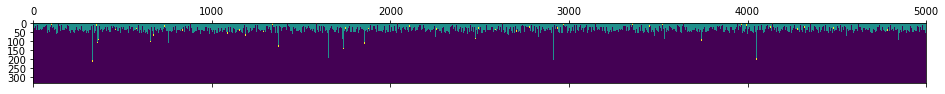

In [15]:
plt.matshow(np.transpose(sepsis_matrix))

## Sepsis keys (feature matrix)

In [16]:
sepsis_idx = np.where(CSCH!=0)
healthy_idx = np.where(CSCH==0) 

In [17]:
# We use features (9) shared by all sepsis patients
s_keys = {}
s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
type(s_keys)
len(s_keys)

9

In [18]:
DATA[0]["HR"].values

array([  nan,  93. ,  91. ,  93. ,  93. ,   nan,  91.5,  94. ,  94. ,
       102. , 106. , 107. , 102. ,  98. ,  95. , 105. ,  94. ,  98. ,
        98. , 105. ,  96. , 102. , 105. , 107. ])

In [19]:
# Feature matrix
feature_matrix = []
patient = []
sepsis_label = []
for i in range(5000):
    initval = 0
    A = initval * np.ones((DATA[i].shape[0],len(s_keys)), dtype=np.double)
    j = 0
    for key in s_keys:
        A[:,j] = DATA[i][key].values
        j = j + 1
       # print (i, key, j)
    A = np.nan_to_num(A)
    sep_lab = (DATA[i]["SepsisLabel"].values).reshape(-1,1)
    if i==0:
        feature_matrix=(A)
        patient = i*np.ones((DATA[i].shape[0],1),dtype=np.int)
        sepsis_label = sep_lab
        
    else: 
        feature_matrix = np.vstack((feature_matrix, A))
        patient = np.vstack((patient, i*np.ones((DATA[i].shape[0],1),dtype=np.int)))
        sepsis_label = np.vstack((sepsis_label, sep_lab))

In [20]:
type(feature_matrix[0])

numpy.ndarray

In [21]:
feature_matrix
np.shape(feature_matrix)

(188453, 9)

In [22]:
# Keep a raw copy
raw_feature_matrix = np.copy(feature_matrix)

In [23]:
patient
np.shape(patient)

(188453, 1)

In [24]:
sepsis_label
np.shape(sepsis_label)

(188453, 1)

In [25]:
# Single entry example
i_e = 90000
print(patient[i_e])
print(feature_matrix[i_e,:])
print(sepsis_label[i_e])


[2378]
[ 89.    98.   120.    70.    50.    62.     0.    -1.38  22.  ]
[0]


## Plot patient features

11 entries x 9 features


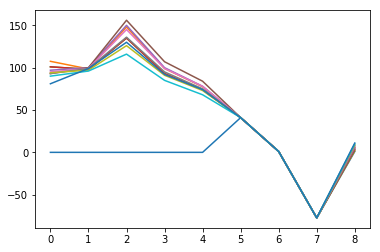

In [30]:
i_pat = 4999

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1], "features")
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)